In [48]:
from PIL import Image, ImageOps
import numpy as np
import math
import matplotlib.pyplot as plt

None
(75, 75)
L


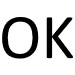

In [80]:
#image = Image.open('op-art-black-and-white-infinity-whirl-tom-hill.jpg')
image = Image.open('ok_gibbs.jpg')
image = ImageOps.grayscale(image)
print(image.format)
print(image.size)
length = image.size[0]
height = image.size[1]
print(image.mode)
# afficher l'image
data = np.asarray(image)
image

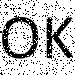

In [128]:
# Constantes

tau = 1.06 # écart-type de yi|xi=k
alpha = 0 # paramètre devant somme xi dans la loi d'Ising
beta = 0.3 # paramètre devant nombre de voisins de même couleur dans la loi d'Ising

def bruiteur(image, proba):
  image_array = data.astype('int16')
  image_array = image_array
  # Pour chaque pixel, on inverse sa couleur avec proba 10 %
  for i in range(np.shape(image_array)[0]):
    for j in range(np.shape(image_array)[1]):
      a = np.random.choice([-1, 1], None, p=[proba, 1-proba])
      if a < 0:
        image_array[i][j] = 255 - image_array[i][j]
  return image_array
bruit_test = bruiteur(image, 0.1) # Bruitage par inversion de 10 % des pixels
from matplotlib import cm
PIL_image = Image.fromarray(np.uint8(bruit_test)).convert('L')
PIL_image

In [129]:
bruit_test_norm = 2*(bruit_test/255)-1 # yi € {-1 ; 1} (image bruitée, 1 = noir, -1 = blanc), xi € {-1 ; 1} (image restaurée, 1 = noir, -1 = blanc)

##Echantilloneur de Gibbs pour sampler selon xi|yi

In [130]:
# Sampler de Gibbs (tau, alpha, beta connus)
# https://towardsdatascience.com/image-denoising-with-gibbs-sampling-mcmc-concepts-and-code-implementation-11d42a90e153
# https://pchanda.github.io/IsingModelDenoising/

def debruiteur(img_bruitee, samples, alpha, beta, tau):
  probas = np.zeros(bruit_test_norm.shape)
  img_random = 2*np.random.randint(2, size=(height, length))-1
  for step in range(samples):
          for i in range(1, img_random.shape[0]-1):
              for j in range(1, img_random.shape[1]-1):
                  y = sample_y(i, j, img_random, img_bruitee, alpha, beta, tau)
                  img_random[i, j] = y
                  if y == 1:
                      probas[i, j] += 1
  probas = probas / samples
  return probas

def sample_y(i, j, Y, X, alpha, beta, tau): #échantillon de P(x[i,j] | V(x[i,j])) (V[x[i,j]] contient les pixels adjacents à x[i,j], et contient y[i,j])
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ((markov_blanket[-1]-1)**2)/(2*tau**2) - alpha + beta * sum(markov_blanket)
    w2 = ((markov_blanket[-1]+1)**2)/(2*tau**2) + alpha - beta * sum(markov_blanket)
    prob = np.exp(w)/(np.exp(w2) + np.exp(w))
    return (np.random.rand() < prob) * 2 - 1
  
probas = debruiteur(bruit_test_norm, 20, alpha, beta, tau)

In [131]:
probas_copy = probas[:]

In [132]:
probas_copy

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.1 , 0.1 , ..., 0.  , 0.05, 0.  ],
       [0.  , 0.65, 0.1 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.8 , 0.2 , ..., 0.2 , 0.25, 0.  ],
       [0.  , 1.  , 0.25, ..., 0.  , 0.05, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

## Pour afficher l'image débruitée

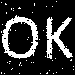

In [133]:
probas_copy[probas_copy > 0.5] = 255
probas_copy[probas_copy <= 0.5] = 0
PIL_image2 = Image.fromarray(np.uint8(probas_copy)).convert('L')
PIL_image2

## Question 2 : tau inconnu, on suppose une loi a priori en Inverse-Gamma

tau estimé : 1.9058432890836206
distance entre images :  15716.159111111112


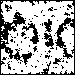

tau estimé : 1.816243806888981
distance entre images :  23362.260444444444


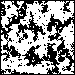

tau estimé : 1.7314537909805858
distance entre images :  37394.785777777775


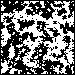

tau estimé : 1.65048562638326
distance entre images :  44339.80711111111


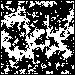

tau estimé : 1.572794625189783
distance entre images :  54803.64711111111


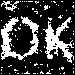

tau estimé : 1.5000124513389375
distance entre images :  58553.03111111111


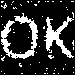

KeyboardInterrupt: ignored

In [137]:
#Q2, a priori inverse-gamma

import math

alpha_ising = 0
beta_ising = 0.3
gamma_inv = 3
rho_inv = 0.5

def sample_y_Q2(i, j, Y, X, alpha, beta, tau): #échantillon de P(x[i,j] | V(x[i,j])) (V[x[i,j]] contient les pixels adjacents à x[i,j], et contient y[i,j])
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ((markov_blanket[-1]-1)**2)/(2*tau**2) - alpha + beta * sum(markov_blanket)
    w2 = ((markov_blanket[-1]+1)**2)/(2*tau**2) + alpha - beta * sum(markov_blanket)
    prob = np.exp(w)/(np.exp(w2) + np.exp(w))
    return (np.random.rand() < prob) * 2 - 1

def metropolis_hastings(target_density, a, b, tau_precedent, size=1):
    burnin_size = 0
    size += burnin_size
    x0 = tau_precedent
    xt = x0
    samples = []
    for i in range(size):
        xt_candidate = np.random.normal(xt, 0.2)
        accept_prob = min((target_density(xt_candidate))/(target_density(xt)), 1)
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    return samples[0]

def debruiteur_Q2(img_bruitee, alpha_ising, beta_ising, gamma_inv, rho_inv, nbre_tirages):
  img_random = 2*np.random.randint(2, size=(height, length))-1
  a,b = img_random.shape
  sim_tau = [2*np.ones((height, length)) for i in range(nbre_tirages)]
  somme_voisins = 0
  samplez = 50
  probas = np.zeros((height, length))
  for step in range(1, nbre_tirages):
    mean_step=np.mean(sim_tau[step-1])
    for s in range(samplez):
      for k in range(1, img_random.shape[0]-1):
        for l in range(1, img_random.shape[1]-1):
          y = sample_y_Q2(k, l, img_random, img_bruitee, alpha_ising, beta_ising, mean_step)
          img_random[k, l] = y
          if y == 1:
            probas[k,l] += 1
          markov_blanket = [img_random[k - 1, l], img_random[k, l - 1], img_random[k, l + 1], img_random[k + 1, l], img_bruitee[k, l]]
          somme_voisins = 0
          for g in range(len(markov_blanket)):
            if (img_random[k,l] == markov_blanket[g]):
              somme_voisins+=1
          fct_actuelle = lambda tau: 1/(tau**(gamma_inv+2))*math.exp(-1/(2*tau**2)*((img_random[k,l] - img_bruitee[k,l])**2) + beta_ising*somme_voisins - rho_inv/tau)
          sim_tau[step][k, l] += metropolis_hastings(fct_actuelle, a, b, sim_tau[step-1][k, l], size=1)
    img_random = 2*(probas/samplez >= 0.5) - 1 # Matrice des y déterminés par Gibbs
    probas = np.zeros((height, length)) # Reset de la matrice probas (sinon l'image disparaît petit à petit)
    sim_tau[step] = np.mean(sim_tau[step])*np.ones((height,length))/samplez
    print("tau estimé :", np.mean(sim_tau[step]))
    img_random[img_random == 1] = 255
    img_random[img_random == -1] = 0
    img_random = np.array(img_random, dtype=np.int64) # image débruitée après l'étape step
    print("distance entre images : ", np.mean(np.square(img_random - data))) # affiche la distance entre l'image débruitée générée et l'image originale
    PIL_image2 = Image.fromarray(np.uint8(img_random)).convert('L')
    display(PIL_image2)
    img_random = 2*np.random.randint(2, size=(height,length)) - 1
  return sim_tau

debruiteur_Q2(bruit_test_norm, alpha_ising, beta_ising, gamma_inv, rho_inv, 100)

In [ ]:
#Q2, a priori inverse-gamma (CODE DYSFONCTIONNEL)

alpha_ising = 0
beta_ising = 0.3
gamma_inv = 0.1
rho_inv = 0.1

def sample_y_Q2(i, j, Y, X, alpha, beta, tau): #échantillon de P(x[i,j] | V(x[i,j])) (V[x[i,j]] contient les pixels adjacents à x[i,j], et contient y[i,j])
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ((markov_blanket[-1]-1)**2)/(2*tau**2) - alpha + beta * sum(markov_blanket)
    w2 = ((markov_blanket[-1]+1)**2)/(2*tau**2) + alpha - beta * sum(markov_blanket)
    prob = np.exp(w)/(np.exp(w2) + np.exp(w))
    return (np.random.rand() < prob) * 2 - 1

def metropolis_hastings(target_density, a, b, tau_precedent, size=1):
    burnin_size = 0
    size += burnin_size
    x0 = tau_precedent
    xt = x0
    samples = []
    for i in range(size):
        xt_candidate = np.random.normal(xt, 0.1)
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
        print()
    return samples[0]

def debruiteur_Q2(img_bruitee, alpha_ising, beta_ising, gamma_inv, rho_inv, nbre_tirages):
  img_random = 2*np.random.randint(2, size=(270, 237))-1
  somme_img = np.sum(img_bruitee)
  a,b = img_random.shape
  sim_tau = [1 for i in range(nbre_tirages)]
  somme_voisins = 0
  def pdf(img_generee, img_bruitee, alpha_ising, beta_ising, gamma_inv, rho_inv, tau_actuel, step, somme_img, somme_voisins):
    pow = tau_actuel**(270*237+gamma_inv+1)
    inv_tau_sq = 1/(2*tau_actuel**2)
    print(tau_actuel)
    print(np.sum(np.square(img_generee-img_bruitee)))
    return (1/pow)*np.exp(-inv_tau_sq*np.sum(np.square(img_generee-img_bruitee)) + alpha_ising*somme_img + beta_ising*somme_voisins - rho_inv/tau_actuel)
  def pdf_appliquee(tau_actuel):
    return pdf(img_random, img_bruitee, alpha_ising, beta_ising, gamma_inv, rho_inv, tau_actuel, step, somme_img, somme_voisins)
  for step in range(1, nbre_tirages):
    for i in range(1, img_random.shape[0]-1):
      for j in range(1, img_random.shape[1]-1):
        y = sample_y_Q2(i, j, img_random, img_bruitee, alpha_ising, beta_ising, sim_tau[step-1])
        img_random[i, j] = y
        markov_blanket = [img_random[i - 1, j], img_random[i, j - 1], img_random[i, j + 1], img_random[i + 1, j], img_bruitee[i, j]]
        somme_voisins = 0
        for g in range(len(markov_blanket)):
          if (img_random[i,j] == markov_blanket[g]):
            somme_voisins+=1
    sim_tau[step] = metropolis_hastings(pdf_appliquee, a, b, sim_tau[step-1], size=1)
  return sim_tau

debruiteur_Q2(bruit_test_norm, alpha_ising, beta_ising, gamma_inv, rho_inv, 100)

In [65]:
data = np.array(data, dtype=np.int64)
bruit_test = np.array(bruit_test, dtype=np.int64)
np.mean(np.square(data - bruit_test))

6052.955047062642

alpha estimé : -4.0952814711050994e-07
beta estimé : 0.3041582079210952
tau estimé : 1.0908393958178877
distance entre images :  4419.999111111111


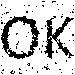

alpha estimé : 9.64951804194215e-06
beta estimé : 0.3233486509391295
tau estimé : 1.1107040514064666
distance entre images :  4947.905777777778


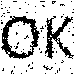

alpha estimé : -4.015572714843342e-05
beta estimé : 0.3417932090465844
tau estimé : 1.12862146216946
distance entre images :  3915.847111111111


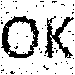

alpha estimé : -3.5423833984435686e-05
beta estimé : 0.35977803654888535
tau estimé : 1.143444246512523
distance entre images :  3223.335111111111


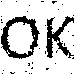

alpha estimé : -4.6315893937131234e-05
beta estimé : 0.37710654235963287
tau estimé : 1.157346469318379
distance entre images :  2734.097777777778


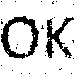

alpha estimé : -7.237911121368459e-05
beta estimé : 0.39398841923262773
tau estimé : 1.1698933251271222
distance entre images :  2807.855111111111


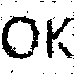

alpha estimé : -0.00010954007307757989
beta estimé : 0.4104836819452284
tau estimé : 1.1806867600735647
distance entre images :  2548.3217777777777


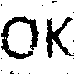

alpha estimé : -0.00013817262358885814
beta estimé : 0.4265218455992639
tau estimé : 1.1910333717806436
distance entre images :  2583.5911111111113


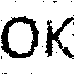

alpha estimé : -0.00016769924656465448
beta estimé : 0.4424909953152384
tau estimé : 1.1994018777335693
distance entre images :  3157.465777777778


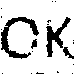

alpha estimé : -0.0002118779803920401
beta estimé : 0.4577645237591627
tau estimé : 1.20654066917612
distance entre images :  3529.607111111111


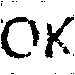

alpha estimé : -0.00026276773123258963
beta estimé : 0.4727907402147133
tau estimé : 1.213197125876841
distance entre images :  5150.817777777777


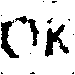

alpha estimé : -0.00028247968101298865
beta estimé : 0.48758151303912683
tau estimé : 1.2188436428652396
distance entre images :  4554.639111111112


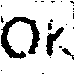

alpha estimé : -0.00034488436651277884
beta estimé : 0.5021532081432131
tau estimé : 1.2243059729268244
distance entre images :  6340.999111111111


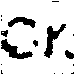

alpha estimé : -0.00036270264933956195
beta estimé : 0.5163509465185747
tau estimé : 1.2291352447647288
distance entre images :  5650.164444444445


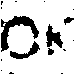

alpha estimé : -0.00041219550279791514
beta estimé : 0.5303123436508703
tau estimé : 1.2329720411112577
distance entre images :  7287.604444444444


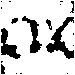

alpha estimé : -0.00047560567501260667
beta estimé : 0.5440219873562632
tau estimé : 1.2362167627490175
distance entre images :  8453.985777777778


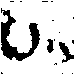

alpha estimé : -0.0004981687900385447
beta estimé : 0.5574119867607201
tau estimé : 1.237675192915131
distance entre images :  11294.345777777778


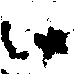

alpha estimé : -0.000556671627801054
beta estimé : 0.5706205430184729
tau estimé : 1.239442380683312
distance entre images :  8981.212444444445


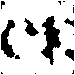

alpha estimé : -0.0005878765451190636
beta estimé : 0.5836235322400801
tau estimé : 1.2396242060683014
distance entre images :  19780.33777777778


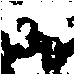

alpha estimé : -0.0006213411041857767
beta estimé : 0.5959803842039213
tau estimé : 1.240470057982781
distance entre images :  16692.956444444444


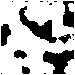

alpha estimé : -0.0006306848161157235
beta estimé : 0.6082151473355958
tau estimé : 1.2403036278003217
distance entre images :  16521.596444444443


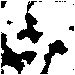

alpha estimé : -0.0006495487233777207
beta estimé : 0.620734474430117
tau estimé : 1.24037301853054
distance entre images :  21788.196444444446


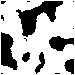

alpha estimé : -0.0006558615068499512
beta estimé : 0.6329592833700007
tau estimé : 1.2398199296954115
distance entre images :  25350.716444444446


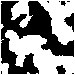

alpha estimé : -0.0006628229910453424
beta estimé : 0.6448585640067485
tau estimé : 1.2390049640043606
distance entre images :  29446.53777777778


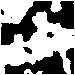

alpha estimé : -0.0006599536549824266
beta estimé : 0.656444000077893
tau estimé : 1.2388366762883363
distance entre images :  24062.751111111113


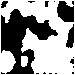

alpha estimé : -0.0006391672353997962
beta estimé : 0.6680211122147672
tau estimé : 1.2372900662369812
distance entre images :  29806.529777777778


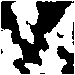

alpha estimé : -0.0005953562943057287
beta estimé : 0.6795562658434169
tau estimé : 1.2350797784135286
distance entre images :  35698.548444444445


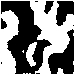

alpha estimé : -0.0006016352933586848
beta estimé : 0.690831257015278
tau estimé : 1.2334521517879902
distance entre images :  32812.991111111114


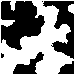

alpha estimé : -0.0005911093993345975
beta estimé : 0.7018885077354126
tau estimé : 1.2312167100875522
distance entre images :  38946.31911111111


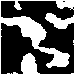

alpha estimé : -0.0005525337588437811
beta estimé : 0.7128687825969174
tau estimé : 1.2289264801476305
distance entre images :  38577.124444444446


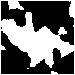

alpha estimé : -0.000554048652181721
beta estimé : 0.7236366999962073
tau estimé : 1.227212692958328
distance entre images :  32741.772444444443


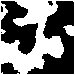

alpha estimé : -0.000566124509690342
beta estimé : 0.7341188045129418
tau estimé : 1.22435366240948
distance entre images :  36238.64977777778


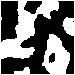

alpha estimé : -0.0005196241348333923
beta estimé : 0.7440433748107748
tau estimé : 1.223149616316934
distance entre images :  33901.26311111111


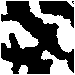

alpha estimé : -0.0004939218573194499
beta estimé : 0.7540892710815102
tau estimé : 1.220194502165895
distance entre images :  41579.188444444444


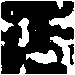

alpha estimé : -0.0004641151376251124
beta estimé : 0.7643718420800786
tau estimé : 1.21563573859183
distance entre images :  45529.53511111111


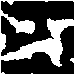

alpha estimé : -0.0004396350753021805
beta estimé : 0.7743496650454116
tau estimé : 1.2135818756782735
distance entre images :  39862.732444444446


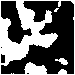

alpha estimé : -0.0004097966003518385
beta estimé : 0.7843842388310279
tau estimé : 1.2091000820236413
distance entre images :  45789.52177777778


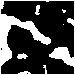

alpha estimé : -0.0003676676971574157
beta estimé : 0.7939815591893276
tau estimé : 1.205344165624613
distance entre images :  42090.04977777778


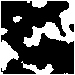

alpha estimé : -0.0003136004732627035
beta estimé : 0.8032426348687858
tau estimé : 1.2013460818260298
distance entre images :  41592.96977777778


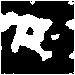

alpha estimé : -0.00028848628455894
beta estimé : 0.812692729029462
tau estimé : 1.1967293802875816
distance entre images :  42178.177777777775


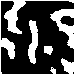

alpha estimé : -0.00023137702404956627
beta estimé : 0.8218064705447109
tau estimé : 1.1913028249652668
distance entre images :  46323.04977777778


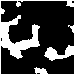

alpha estimé : -0.000191090513892767
beta estimé : 0.8308243557950933
tau estimé : 1.1862482758276178
distance entre images :  46548.71911111111


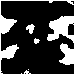

alpha estimé : -0.00016975010070600433
beta estimé : 0.8396519840376134
tau estimé : 1.181548315441626
distance entre images :  44941.10844444444


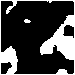

alpha estimé : -0.0001785612326161822
beta estimé : 0.8478905887408495
tau estimé : 1.1761763188995826
distance entre images :  45415.65777777778


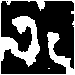

alpha estimé : -0.00018068695098774572
beta estimé : 0.8559085186119408
tau estimé : 1.1729391709026935
distance entre images :  39080.50577777778


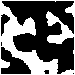

alpha estimé : -0.00014009344576657192
beta estimé : 0.8640202894296845
tau estimé : 1.1686719053473107
distance entre images :  41838.13244444445


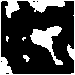

alpha estimé : -0.00010337313757612496
beta estimé : 0.8723048385770255
tau estimé : 1.1618349547680906
distance entre images :  46525.281777777775


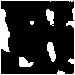

alpha estimé : -9.109558544586768e-05
beta estimé : 0.8801276192129383
tau estimé : 1.1571734216770349
distance entre images :  43758.86044444444


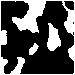

alpha estimé : -5.286784150761909e-05
beta estimé : 0.8877434165362518
tau estimé : 1.1515811232753344
distance entre images :  45409.40177777778


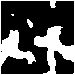

alpha estimé : -4.0706224234077174e-05
beta estimé : 0.895361739025696
tau estimé : 1.1460355784447758
distance entre images :  45391.90311111111


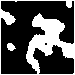

alpha estimé : -2.732929386718897e-05
beta estimé : 0.9025338210975823
tau estimé : 1.1433344046456013
distance entre images :  41510.10044444445


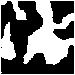

alpha estimé : -8.936949970208697e-06
beta estimé : 0.9098594541084263
tau estimé : 1.1414622577025668
distance entre images :  38133.311111111114


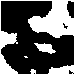

alpha estimé : 2.955610328470964e-07
beta estimé : 0.9170940452825261
tau estimé : 1.1352833921377161
distance entre images :  46592.14844444444


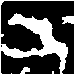

alpha estimé : 5.7840433244154184e-05
beta estimé : 0.9242955103945371
tau estimé : 1.1304208498527235
distance entre images :  42622.217777777776


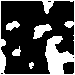

alpha estimé : 9.827529160823569e-05
beta estimé : 0.9312450109852362
tau estimé : 1.1236775676495008
distance entre images :  47893.804444444446


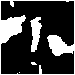

alpha estimé : 0.0001389168259016773
beta estimé : 0.9379570799026281
tau estimé : 1.1196272978787454
distance entre images :  41763.01511111111


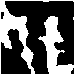

alpha estimé : 0.0001564433064735296
beta estimé : 0.9447147605099796
tau estimé : 1.1157695924879392
distance entre images :  43129.044444444444


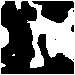

alpha estimé : 0.00019832678469663582
beta estimé : 0.9512750070753304
tau estimé : 1.1091484708585466
distance entre images :  48117.07111111111


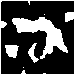

alpha estimé : 0.00021556595343247986
beta estimé : 0.9575318113287411
tau estimé : 1.106498348303849
distance entre images :  41971.91111111111


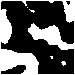

alpha estimé : 0.0002335729097903539
beta estimé : 0.9634396655722317
tau estimé : 1.102472956439273
distance entre images :  42182.80177777778


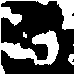

alpha estimé : 0.000246807062167494
beta estimé : 0.9692573629078964
tau estimé : 1.097650858540237
distance entre images :  44145.05511111111


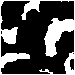

alpha estimé : 0.0002696713016073917
beta estimé : 0.9748877980553234
tau estimé : 1.0945152616027007
distance entre images :  42319.25511111111


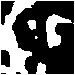

alpha estimé : 0.0002532695516775715
beta estimé : 0.9804547422815305
tau estimé : 1.088889639631217
distance entre images :  44842.508444444444


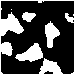

alpha estimé : 0.0003052729815504926
beta estimé : 0.9868757210201201
tau estimé : 1.0815318126004936
distance entre images :  46058.620444444445


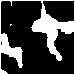

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in exp


alpha estimé : 0.0002934403874088189
beta estimé : 0.9922751236095029
tau estimé : 1.0788336305236115
distance entre images :  39956.980444444445


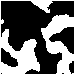

alpha estimé : 0.00032993331914297434
beta estimé : 0.9980762315317859
tau estimé : 1.0718064945558436
distance entre images :  47422.92711111111


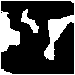

alpha estimé : 0.0003512512910955911
beta estimé : 1.003334899643742
tau estimé : 1.066726210533421
distance entre images :  43383.455111111114


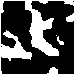

alpha estimé : 0.00036404006128204345
beta estimé : 1.0081421268429565
tau estimé : 1.064437928095691
distance entre images :  39813.31911111111


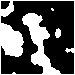

alpha estimé : 0.0004087282437917284
beta estimé : 1.0131665594566925
tau estimé : 1.062965125404519
distance entre images :  39244.97511111111


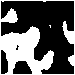

alpha estimé : 0.000460127936116642
beta estimé : 1.017788589900046
tau estimé : 1.0617664813686785
distance entre images :  37990.96444444444


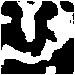

alpha estimé : 0.0004940263662874025
beta estimé : 1.0225294199291233
tau estimé : 1.0566580786153972
distance entre images :  44082.177777777775


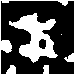

alpha estimé : 0.0005362337274829829
beta estimé : 1.0269818209306474
tau estimé : 1.051837869875664
distance entre images :  44313.55911111111


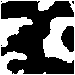

alpha estimé : 0.0005582026677765769
beta estimé : 1.0314158242887175
tau estimé : 1.0509671076738794
distance entre images :  38364.96444444444


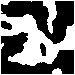

alpha estimé : 0.0005644730539662594
beta estimé : 1.0359980416355796
tau estimé : 1.0468706708531348
distance entre images :  42914.93511111111


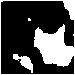

alpha estimé : 0.0005698963530323862
beta estimé : 1.0399728813992384
tau estimé : 1.046283756111529
distance entre images :  37190.105777777775


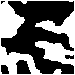

alpha estimé : 0.0005604610236105757
beta estimé : 1.044170127425239
tau estimé : 1.0421483441985535
distance entre images :  42796.47911111111


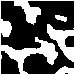

alpha estimé : 0.0005917598653736531
beta estimé : 1.0481096640569805
tau estimé : 1.0393650425019438
distance entre images :  42933.703111111114


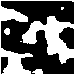

alpha estimé : 0.0006349051345818092
beta estimé : 1.051825584639635
tau estimé : 1.0370262148310252
distance entre images :  40255.40977777778


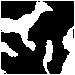

alpha estimé : 0.0006527975263013456
beta estimé : 1.05561837243086
tau estimé : 1.0365051414879136
distance entre images :  38771.69511111111


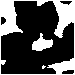

alpha estimé : 0.0006475867879729634
beta estimé : 1.0593489166250167
tau estimé : 1.0355712621962356
distance entre images :  39676.412444444446


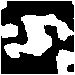

alpha estimé : 0.0006973230075788982
beta estimé : 1.0631909961442145
tau estimé : 1.0306948500826056
distance entre images :  43826.67911111111


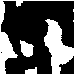

alpha estimé : 0.0007393600603445656
beta estimé : 1.0668399019935497
tau estimé : 1.0243785083768389
distance entre images :  43975.281777777775


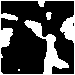

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


alpha estimé : 0.0007400586270641614
beta estimé : 1.0706059320338774
tau estimé : 1.0193929353550037
distance entre images :  43450.36711111111


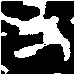

alpha estimé : 0.0007403252286716975
beta estimé : 1.0738341206663757
tau estimé : 1.0198433689232456
distance entre images :  38076.961777777775


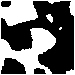

KeyboardInterrupt: ignored

In [121]:
#Q3
# A prioris :
# alpha ~ exp(theta) où theta grand
# beta ~ Rayleigh(sigma)
# tau ~ Inverse-Gamma(gamma, rho)
# X ~ Ising(alpha, beta)

import math

gamma_inv = 3
rho_inv = 0.5
theta_exp = 0.5
sigma_rayleigh = 2

def sample_y_Q3(i, j, Y, X, alpha, beta, tau): #échantillon de P(x[i,j] | V(x[i,j])) (V[x[i,j]] contient les pixels adjacents à x[i,j], et contient y[i,j])
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ((markov_blanket[-1]-1)**2)/(2*tau**2) - alpha + beta * sum(markov_blanket)
    w2 = ((markov_blanket[-1]+1)**2)/(2*tau**2) + alpha - beta * sum(markov_blanket)
    prob = np.exp(w)/(np.exp(w2) + np.exp(w))
    return (np.random.rand() < prob) * 2 - 1

def metropolis_hastings(target_density, a, b, tau_precedent, std_choice, size=1):
    burnin_size = 0
    size += burnin_size
    x0 = tau_precedent
    xt = x0
    samples = []
    for i in range(size):
        xt_candidate = np.random.normal(xt, std_choice)
        accept_prob = min((target_density(xt_candidate))/(target_density(xt)), 1)
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    return samples[0]

def debruiteur_Q3(img_bruitee, gamma_inv, rho_inv, theta_exp, sigma_rayleigh, nbre_tirages):
  img_random = 2*np.random.randint(2, size=(height, length))-1
  a,b = img_random.shape
  sim_tau = [1.13*np.ones((height, length)) for i in range(nbre_tirages)]
  sim_alpha = [0*np.ones((height, length)) for i in range(nbre_tirages)]
  sim_beta = [0.3*np.ones((height, length)) for i in range(nbre_tirages)]
  somme_voisins = 0
  samplez = 50
  probas = np.zeros((height, length))
  for step in range(1, nbre_tirages):
    mean_alpha=np.mean(sim_alpha[step-1])
    mean_beta=np.mean(sim_beta[step-1])
    mean_tau=np.mean(sim_tau[step-1])
    sum_alpha, sum_beta, sum_tau = np.zeros((height, length)), np.zeros((height, length)), np.zeros((height, length))
    for s in range(samplez):
      sampled_alpha_copy, sampled_beta_copy, sampled_tau_copy = np.zeros((height, length)), np.zeros((height, length)), np.zeros((height, length))
      for k in range(1, img_random.shape[0]-1):
        for l in range(1, img_random.shape[1]-1):
          y = sample_y_Q3(k, l, img_random, img_bruitee, mean_alpha, mean_beta, mean_tau)
          img_random[k, l] = y
          if y == 1:
            probas[k,l] += 1
          markov_blanket = [img_random[k - 1, l], img_random[k, l - 1], img_random[k, l + 1], img_random[k + 1, l], img_bruitee[k, l]]
          somme_voisins = 0
          for g in range(len(markov_blanket)):
            if (img_random[k,l] == markov_blanket[g]):
              somme_voisins+=1
          densite_sampling_A = lambda A: np.exp(A*img_random[k,l] + sim_beta[step-1][k,l]*somme_voisins - 1/(2*sim_tau[step-1][k,l]**2)*(img_random[k,l] - img_bruitee[k,l])**2 - abs(A)/theta_exp)
          sampled_alpha_copy[k, l] = metropolis_hastings(densite_sampling_A, a, b, sim_alpha[step-1][k,l], std_choice = 0, size=1)
          sim_alpha[step][k, l] = sampled_alpha_copy[k, l]
          densite_sampling_B = lambda B: np.exp(sim_alpha[step][k,l]*img_random[k,l] + B*somme_voisins - (-1/(2*sim_tau[step-1][k,l]**2)*(img_random[k,l] - img_bruitee[k,l])**2) - B**2/(2*sigma_rayleigh**2))*B
          sampled_beta_copy[k, l] = metropolis_hastings(densite_sampling_B, a, b, sim_beta[step-1][k,l], std_choice = 0.1, size=1)
          sim_beta[step][k, l] = sampled_beta_copy[k, l]
          densite_sampling_tau = lambda tau: 1/(tau**(gamma_inv+2))*np.exp(-1/(2*tau**2)*((img_random[k,l] - img_bruitee[k,l])**2) + sim_beta[step][k,l]*somme_voisins + sim_alpha[step][k,l]*img_random[k,l] - rho_inv/tau)
          sampled_tau_copy[k, l] = metropolis_hastings(densite_sampling_tau, a, b, sim_tau[step-1][k, l], std_choice=0.2, size=1)
          sim_tau[step][k, l] = sampled_tau_copy[k, l]
      sum_alpha += sampled_alpha_copy
      sum_beta += sampled_beta_copy
      sum_tau += sampled_tau_copy
    img_random = 2*(probas/samplez <= 0.5) - 1 # Matrice des y déterminés par Gibbs
    probas = np.zeros((height, length)) # Reset de la matrice probas (sinon l'image disparaît petit à petit)
    sim_alpha[step] = sum_alpha*np.ones((height, length))/samplez
    sim_beta[step] = sum_beta*np.ones((height, length))/samplez
    sim_tau[step] = sum_tau*np.ones((height, length))/samplez
    print("alpha estimé :", np.mean(sim_alpha[step]))
    print("beta estimé :", np.mean(sim_beta[step]))
    print("tau estimé :", np.mean(sim_tau[step]))
    img_random[img_random == 1] = 255
    img_random[img_random == -1] = 0
    img_random = np.array(img_random, dtype=np.int64) # image débruitée après l'étape step
    print("distance entre images : ", np.mean(np.square(img_random - data))) # affiche la distance entre l'image débruitée générée et l'image originale
    PIL_image2 = Image.fromarray(np.uint8(img_random)).convert('L')
    display(PIL_image2)
    img_random = 2*np.random.randint(2, size=(height, length)) - 1
  return sim_tau, sim_beta, sim_alpha

debruiteur_Q3(bruit_test_norm, alpha_ising, beta_ising, gamma_inv, rho_inv, 100)